#### limpieza y pre-procesamiento
- eliminacion de repetidos
- one-hot para la columna 'VisitorType'
- correccion de inconsistencias con kNN.
- dos columnas booleanas cambiadas a binarias

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wget import download
from os import path

# leemos los datos del archivo
dataset_compras = pd.read_csv("online_shoppers_intention.csv")
dataset_compras.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [122]:
# Eliminar duplicados exactos (mantiene la primera ocurrencia)
df = dataset_compras.drop_duplicates(keep='first')

print(f"📊 ANTES: {len(dataset_compras)} registros")
print(f"📊 DESPUÉS: {len(df)} registros")
print(f"🗑️  Se eliminaron {len(dataset_compras) - len(df)} registros duplicados")

📊 ANTES: 12330 registros
📊 DESPUÉS: 12205 registros
🗑️  Se eliminaron 125 registros duplicados


In [123]:

def corregir_inconsistencias_knn(df):
    """
    Corrige inconsistencias usando K-Nearest Neighbors
    """
    df_corregido = df.copy()
    
    # 1. INCONSISTENCIAS GRAVES: Páginas=0 pero Duración>0
    # Para estas, la duración DEBE ser 0
    mascara_admin = (df['Administrative'] == 0) & (df['Administrative_Duration'] > 0)
    mascara_info = (df['Informational'] == 0) & (df['Informational_Duration'] > 0)
    mascara_prod = (df['ProductRelated'] == 0) & (df['ProductRelated_Duration'] > 0)
    
    df_corregido.loc[mascara_admin, 'Administrative_Duration'] = 0
    df_corregido.loc[mascara_info, 'Informational_Duration'] = 0
    df_corregido.loc[mascara_prod, 'ProductRelated_Duration'] = 0
    
    print(f"✅ Corregidas {mascara_admin.sum()} inconsistencias en Administrative")
    print(f"✅ Corregidas {mascara_info.sum()} inconsistencias en Informational")
    print(f"✅ Corregidas {mascara_prod.sum()} inconsistencias en ProductRelated")
    
    # 2. INCONSISTENCIAS LEVES: Páginas>0 pero Duración=0
    # Para estas, usaremos K-NN para imputar valores razonables
    features_para_knn = [
        'Administrative', 'Administrative_Duration',
        'Informational', 'Informational_Duration', 
        'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates', 'PageValues'
    ]
    
    # Preparar datos para K-NN
    df_knn = df_corregido[features_para_knn].copy()
    
    # Aplicar K-NN para cada tipo de inconsistencia leve
    for page_type in ['Administrative', 'Informational', 'ProductRelated']:
        duration_col = f'{page_type}_Duration'
        
        # Identificar inconsistencias leves
        mascara_leve = (df_corregido[page_type] > 0) & (df_corregido[duration_col] == 0)
        
        if mascara_leve.sum() > 0:
            print(f"\n🔧 Aplicando K-NN a {mascara_leve.sum()} registros de {page_type}>0 y Duration=0")
            
            # Para estos registros, usar K-NN para predecir duración
            # (implementación simplificada - podrías usar sklearn KNNImputer)
            duracion_promedio = df_corregido[
                (df_corregido[page_type] > 0) & (df_corregido[duration_col] > 0)
            ][duration_col].mean()
            
            # Asignar duración promedio basada en número de páginas similares
            df_corregido.loc[mascara_leve, duration_col] = duracion_promedio * 0.5  # Conservador
    
    return df_corregido

# Aplicar corrección
df = corregir_inconsistencias_knn(df)

✅ Corregidas 0 inconsistencias en Administrative
✅ Corregidas 0 inconsistencias en Informational
✅ Corregidas 0 inconsistencias en ProductRelated

🔧 Aplicando K-NN a 135 registros de Administrative>0 y Duration=0

🔧 Aplicando K-NN a 226 registros de Informational>0 y Duration=0

🔧 Aplicando K-NN a 592 registros de ProductRelated>0 y Duration=0


In [124]:
# Convertir booleanos a binarios (True=1, False=0)
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

print("✅ Columnas convertidas a binarias:")
print(f"Weekend: {df['Weekend'].unique()}")
print(f"Revenue: {df['Revenue'].unique()}")

✅ Columnas convertidas a binarias:
Weekend: [0 1]
Revenue: [0 1]


In [125]:
# One-Hot Encoding con get_dummies
visitor_dummies = pd.get_dummies(df['VisitorType'], prefix='Visitor')

# Concatenar con el dataset original
df = pd.concat([df, visitor_dummies], axis=1)

# Eliminar la columna original (opcional)
df = df.drop('VisitorType', axis=1)


df["Visitor_New_Visitor"] = df['Visitor_New_Visitor'].astype(int)
df["Visitor_Other"] = df['Visitor_Other'].astype(int)
df["Visitor_Returning_Visitor"] = df['Visitor_Returning_Visitor'].astype(int)

print("✅ One-Hot Encoding completado:")
print(f"Columnas creadas: {list(visitor_dummies.columns)}")



✅ One-Hot Encoding completado:
Columnas creadas: ['Visitor_New_Visitor', 'Visitor_Other', 'Visitor_Returning_Visitor']


In [126]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Visitor_New_Visitor,Visitor_Other,Visitor_Returning_Visitor
0,0,0.0,0,0.0,1,636.337836,0.20,0.20,0.0,0.0,Feb,1,1,1,1,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,0,0,0,0,1
2,0,0.0,0,0.0,1,636.337836,0.20,0.20,0.0,0.0,Feb,4,1,9,3,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,1,0,0,0,1


#### PLANTEO DE HIPOTESIS : UNIVARIADAS

##### Hipótesis 1 : La mayoria de las compras se realizan en el ultimo trimestre del anio.

deberiamos agrupar (pre-procesamiento) los meses en trimestres?

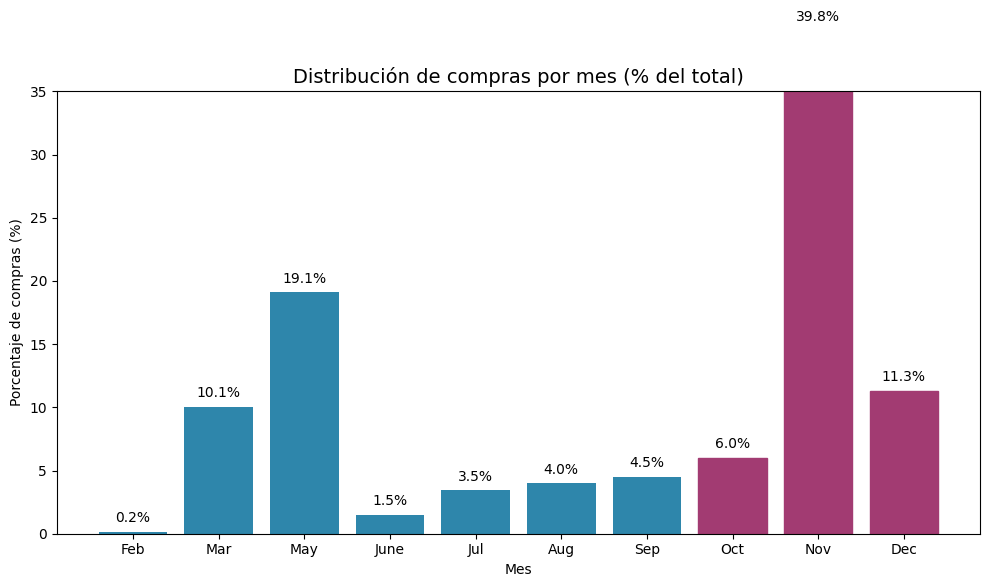

Total de compras registradas: 1908
Porcentaje de compras en Oct–Dic: 57.2%


In [127]:
# 1. Filtrar solo las sesiones con Revenue = TRUE
df_compras = df[df['Revenue'] == 1]

# 2. Contar compras por mes
compras_por_mes = df_compras['Month'].value_counts().reindex(
    ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    fill_value=0
)

# 3. Calcular porcentaje del total
total_compras = compras_por_mes.sum()
porcentaje_por_mes = (compras_por_mes / total_compras) * 100

# 4. Calcular porcentaje para el trimestre Oct–Dic
trimestre_oct_dic = porcentaje_por_mes[['Oct', 'Nov', 'Dec']].sum()

# 5. Visualización
plt.figure(figsize=(10, 6))
bars = plt.bar(porcentaje_por_mes.index, porcentaje_por_mes.values, color='#2E86AB')
plt.title('Distribución de compras por mes (% del total)', fontsize=14)
plt.ylabel('Porcentaje de compras (%)')
plt.xlabel('Mes')
plt.ylim(0, 35)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Resaltar Oct–Dic
for i, mes in enumerate(porcentaje_por_mes.index):
    if mes in ['Oct', 'Nov', 'Dec']:
        bars[i].set_color('#A23B72')

plt.tight_layout()
plt.show()

# 6. Mostrar conclusión numérica
print(f"Total de compras registradas: {total_compras}")
print(f"Porcentaje de compras en Oct–Dic: {trimestre_oct_dic:.1f}%")

##### Hipotesis 2 : “La gran mayoría de las sesiones ocurren en fechas cercanas a eventos promocionales o festivos (SpecialDay = 0), lo que indica que el tráfico está fuertemente impulsado por el calendario de campañas.” 

Total de sesiones: 12205
Sesiones con SpecialDay = 0: 10956
Proporción de sesiones cerca de días festivos: 89.8%

Distribución de SpecialDay:
SpecialDay
0.0    10956
0.2      178
0.4      243
0.6      350
0.8      324
1.0      154
Name: count, dtype: int64


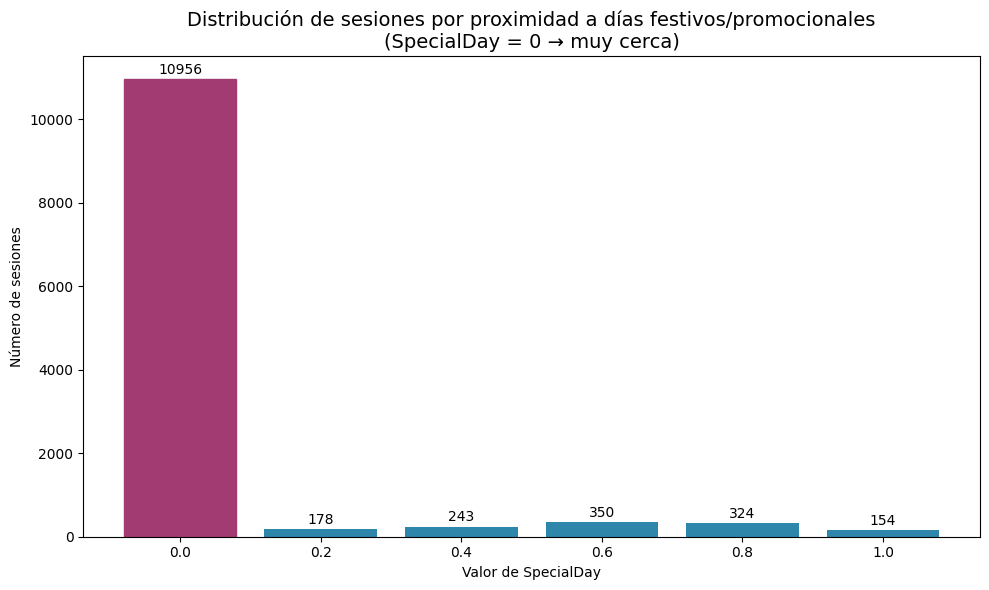

In [130]:
# Proporción de sesiones con SpecialDay = 0 (cerca de día festivo)
prop_cerca_festivo = (df['SpecialDay'] == 0).mean()
total_sesiones = len(df)
specialday_counts = df['SpecialDay'].value_counts().sort_index()
print(f"Total de sesiones: {total_sesiones}")
print(f"Sesiones con SpecialDay = 0: {(df['SpecialDay'] == 0).sum()}")
print(f"Proporción de sesiones cerca de días festivos: {prop_cerca_festivo:.1%}")

print("\nDistribución de SpecialDay:")
print(df['SpecialDay'].value_counts().sort_index())


# 3. Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(specialday_counts.index.astype(str), specialday_counts.values, color='#2E86AB')
plt.title('Distribución de sesiones por proximidad a días festivos/promocionales\n(SpecialDay = 0 → muy cerca)', fontsize=14)
plt.xlabel('Valor de SpecialDay')
plt.ylabel('Número de sesiones')
plt.xticks(rotation=0)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Resaltar la barra de SpecialDay = 0
bars[0].set_color('#A23B72')

plt.tight_layout()
plt.show()


##### Hipotesis 3 : "La mayoría de las compras están asociadas a sesiones de usuarios que ya visitaron el sitio y tienen experiencia previa, lo cual se evidencia al observar que los 'Returning_Visitor' representan la cantidad más alta de transacciones en comparación con 'New_Visitor' y 'Other'."

A nuestra interpretacion, las campanas de marketing para nuevos clientes funcionan atrayendo trafico, pero no ayudan a compras durante la primera visita a la pagina.



🛒 COMPRAS REALIZADAS POR TIPO DE VISITANTE (One-Hot Encoding)
• New_Visitor: 422 compras (22.1%)
• Other: 16 compras (0.8%)
• Returning_Visitor: 1470 compras (77.0%)

📊 TOTAL: 1908 compras analizadas


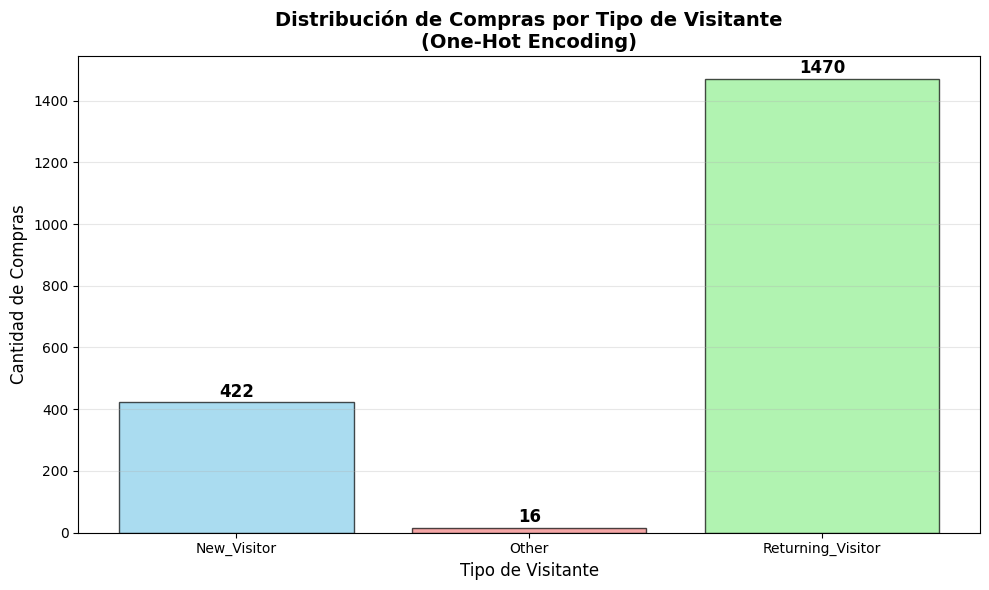

In [129]:
# Suponiendo que tus columnas one-hot son:
# 'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor', 'VisitorType_Other'

# 1. Filtrar solo las compras
compras_dataset = df[df['Revenue'] == True]

# 2. Contar compras por cada categoría one-hot
columnas_visitor = [col for col in df.columns if 'Visitor_' in col]

print("🛒 COMPRAS REALIZADAS POR TIPO DE VISITANTE (One-Hot Encoding)")
print("="*60)

compras_por_tipo = {}
total_compras = len(compras_dataset)

for col in columnas_visitor:
    # Contar cuántas compras tienen valor 1 en cada columna one-hot
    cantidad = compras_dataset[col].sum()
    nombre_tipo = col.replace('Visitor_', '')  # Remover prefijo
    compras_por_tipo[nombre_tipo] = cantidad
    porcentaje = (cantidad / total_compras) * 100
    print(f"• {nombre_tipo}: {int(cantidad)} compras ({porcentaje:.1f}%)")

print(f"\n📊 TOTAL: {total_compras} compras analizadas")

tipos = list(compras_por_tipo.keys())
cantidades = list(compras_por_tipo.values())

plt.figure(figsize=(10, 6))
barras = plt.bar(tipos, cantidades, color=['skyblue', 'lightcoral', 'lightgreen'], 
                 alpha=0.7, edgecolor='black')

# Agregar valores en las barras
for barra, valor in zip(barras, cantidades):
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 5, 
             f'{int(valor)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.xlabel('Tipo de Visitante', fontsize=12)
plt.ylabel('Cantidad de Compras', fontsize=12)
plt.title('Distribución de Compras por Tipo de Visitante\n(One-Hot Encoding)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

###### Hipotesis: Cuanto mas tiempo en total consume la sesion,mayor es el valor de PageValues.

Con un valor de Page Values alto se verifica que los objetivos impuestos por el creador de la pagina se cumplieron(goals).
